# Sample registration of an image to patterns

Since thre is still an deformation among input images and its representation we look for a descriptive transformations...

In [1]:
%matplotlib inline
import time
import numpy as np
from skimage import draw
import matplotlib.pylab as plt

## Input images

In [2]:
# STATIC IMAGE - from atlas
img_static = np.zeros((128, 128), dtype=int)
x, y = draw.ellipse(40, 60, 20, 50, shape=img_static.shape)
img_static[x, y] = 1
x, y = draw.ellipse(80, 70, 30, 40, shape=img_static.shape)
img_static[x, y] = 1
# MOVING IMAGE - sensed
img_moving = np.zeros(img_static.shape, dtype=int)
x, y = draw.ellipse(60, 70, 40, 50, shape=img_moving.shape)
img_moving[x, y] = 1

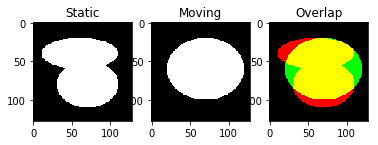

In [3]:
plt.subplot(1, 3, 1), plt.imshow(img_static, cmap=plt.cm.Greys_r), plt.title('Static')
plt.subplot(1, 3, 2), plt.imshow(img_moving, cmap=plt.cm.Greys_r), plt.title('Moving')
im_overlap = np.rollaxis(np.array([img_static, img_moving, np.zeros(img_static.shape)]), 0, 3)
_= plt.subplot(1, 3, 3), plt.imshow(im_overlap), plt.title('Overlap')

In [5]:
def showregist_overlap(img_warped, img_static, img_moving):
    _= plt.subplot(1, 3, 1), plt.imshow(img_warped), plt.title('Warped')
    im_overlap = np.rollaxis(np.array([img_static, img_warped, np.zeros(img_static.shape)]), 0, 3)
    _= plt.subplot(1, 3, 2), plt.imshow(im_overlap), plt.title('W-S (to goal)')
    im_overlap = np.rollaxis(np.array([img_moving, img_warped, np.zeros(img_static.shape)]), 0, 3)
    _= plt.subplot(1, 3, 3), plt.imshow(im_overlap), plt.title('W-M (from init.)')

## Demons: classic

This [example](http://simpleitk.readthedocs.io/en/master/Examples/DemonsRegistration1/Documentation.html) illustrates how to use the classic Demons registration algorithm. The user supplied parameters for the algorithm are the number of iterations and the standard deviations for the Gaussian smoothing of the total displacement field. Additional methods which control regularization, total field smoothing for elastic model or update field smoothing for viscous model are available.

In [6]:
import SimpleITK as sitk

fixed = sitk.GetImageFromArray(img_static)
moving = sitk.GetImageFromArray(img_moving)

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(256)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

In [7]:
demons = sitk.DemonsRegistrationFilter()
demons.SetNumberOfIterations(500)
demons.SetSmoothDisplacementField(True)
demons.SetStandardDeviations(0.5)
demons.SetSmoothUpdateField(True)
demons.SetUpdateFieldStandardDeviations(0.5)

t = time.time()
displacement_field = demons.Execute(fixed, moving)
out_transf = sitk.DisplacementFieldTransform(displacement_field)
print ('demons took:', time.time() - t)

demons took: 2.588244676589966


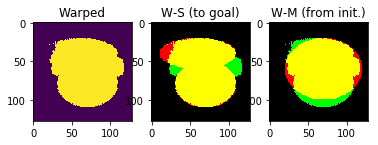

In [8]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(out_transf)

warped = resampler.Execute(moving)
showregist_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

## Demons: fast symmetric forces

This [example](http://simpleitk.readthedocs.io/en/master/Examples/DemonsRegistration2/Documentation.html) illustrates how to use the fast symmetric forces Demons algorithm. As the name implies, unlike the classical algorithm, the forces are symmetric.

In [9]:
import SimpleITK as sitk

fixed = sitk.GetImageFromArray(img_static)
moving = sitk.GetImageFromArray(img_moving)

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(256)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

In [11]:
demons = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons.SetNumberOfIterations(500)
demons.SetSmoothDisplacementField(True)
demons.SetStandardDeviations(0.5)
demons.SetSmoothUpdateField(True)
demons.SetUpdateFieldStandardDeviations(0.1)

t = time.time()
displacement_field = demons.Execute(fixed, moving)
out_transf = sitk.DisplacementFieldTransform(displacement_field)
print ('demons took:', time.time() - t)

demons took: 2.5396127700805664


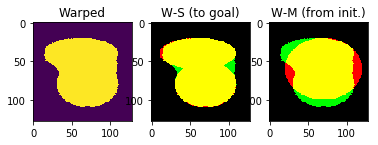

In [12]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(out_transf)

out = resampler.Execute(moving)
showregist_overlap(sitk.GetArrayViewFromImage(out), img_static, img_moving)

## Symmetric Diffeomorphic Registration

This [example](http://nipy.org/dipy/examples_built/syn_registration_2d.html#example-syn-registration-2d) explains how to register 2D images using the Symmetric Normalization (SyN) algorithm proposed by Avants et al. [Avants09](https://doi.org/10.1016/j.media.2007.06.004) (also implemented in the ANTS software [Avants11](http://scil.dinf.usherbrooke.ca/wp-content/courses/imn530/ants.pdf))

In [13]:
from dipy.data import get_data
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric #, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
from dipy.viz import regtools

# regtools.overlay_images(img_static, img_moving, 'Static', 'Overlay', 'Moving', '')

In [14]:
from dipy.align.imwarp import RegistrationStages as sStages

def print_deform(obj, stage):
    if stage not in [sStages.INIT_END, sStages.ITER_END, sStages.OPT_END, sStages.ITER_END]:
        return 
    nb_pxls = np.prod(obj.moving_to_ref.forward.shape)
    deform_f = obj.moving_to_ref.forward
    deform_b = obj.static_to_ref.forward
    print('stage:', stage, '...', 
          'deform B:', np.sum(abs(deform_b)) / nb_pxls, 
          'deform F:', np.sum(abs(deform_f)) / nb_pxls)

Creating scale space from the moving image. Levels: 2. Sigma factor: 0.500000.
Creating scale space from the static image. Levels: 2. Sigma factor: 0.500000.
Optimizing level 1
stage: 7 ... deform B: 0.289460271597 deform F: 0.229038536549
stage: 7 ... deform B: 0.518074989319 deform F: 0.418068915606
stage: 7 ... deform B: 0.665300250053 deform F: 0.545708954334
stage:

 7 ... deform B: 0.768486618996 deform F: 0.636620461941
stage: 7 ... deform B: 0.796997189522 deform F: 0.644313812256
Optimizing level 0
stage: 7 ... deform B: 0.832797110081 deform F: 0.661017477512
stage:

 7 ... deform B: 0.830233931541 deform F: 0.654797554016
stage: 7 ... deform B: 0.867777049541 deform F: 0.683326900005
stage: 7 ... deform B: 0.845991492271 deform F: 0.662010908127
stage:

 7 ... deform B: 0.878453850746 deform F: 0.691100239754
stage: 7 ... deform B: 0.853961765766 deform F: 0.668981850147
stage:

 7 ... deform B: 0.884616672993 deform F: 0.696106612682
stage: 7 ... deform B: 0.85786741972 deform F: 0.673200190067
stage:

 7 ... deform B: 0.88961482048 deform F: 0.701890826225
stage: 7 ... deform B: 0.861510515213 deform F: 0.679449796677
stage: 3 ... deform B: 1.48468518257 deform F: 0.679449796677
optimize took: 0.35295963287353516


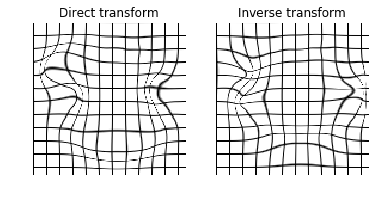

In [16]:
sdr = SymmetricDiffeomorphicRegistration(metric=SSDMetric(img_static.ndim), 
                                         step_length=1., 
                                         level_iters=[5, 10], 
                                         inv_iter=2, 
                                         ss_sigma_factor=0.5,
                                         opt_tol=1.e-2,
                                         callback=print_deform)

t = time.time()
mapping = sdr.optimize(img_static, img_moving)
print ('optimize took:', time.time() - t)

_= regtools.plot_2d_diffeomorphic_map(mapping, 10)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7bb7f77f60>,
 <matplotlib.image.AxesImage at 0x7f7b96fa22e8>)

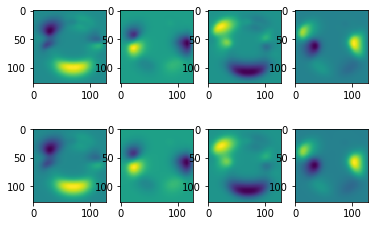

In [18]:
from scipy.ndimage.filters import gaussian_filter

plt.subplot(2, 4, 1), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 2), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 3), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 4), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

m_sigma = [3, 3, 0]
mapping.forward = gaussian_filter(mapping.forward, sigma=m_sigma)
mapping.backward = gaussian_filter(mapping.backward, sigma=m_sigma)

plt.subplot(2, 4, 5), plt.imshow(mapping.forward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 6), plt.imshow(mapping.forward[..., 1], interpolation='nearest')
plt.subplot(2, 4, 7), plt.imshow(mapping.backward[..., 0], interpolation='nearest')
plt.subplot(2, 4, 8), plt.imshow(mapping.backward[..., 1], interpolation='nearest')

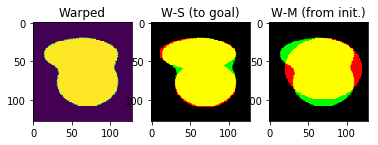

In [20]:
img_warped = mapping.transform(img_moving, 'linear')
showregist_overlap(img_warped, img_static, img_moving)